<a href="https://colab.research.google.com/github/JHyunjun/torch_GAN/blob/main/cgan_mnist_ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 조건적 GAN - MNIST

GAN 첫걸음, 2020

In [20]:
# 라이브러리 임포트

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset 클래스

In [21]:
# Dataset 클래스

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # 이미지 타겟목표 (레이블)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 0-255의 이미지를 표준화시켜서 0-1로 변환 표준화
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # 레이블, 이미지 데이터 텐서와, 타겟목표 텐서 반환
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [22]:
# 데이터 로드

mnist_dataset = MnistDataset('/content/sample_data/mnist_test.csv')

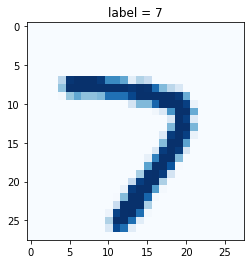

In [23]:
# 데이터 확인

mnist_dataset.plot_image(17)

## 데이터 함수

In [24]:
# 임의의 데이터 생성 함수

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

## 판별기 모델

In [25]:
# Discriminator 클래스

class Discriminator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
       # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # 손실 함수 생성
        self.loss_function = nn.BCELoss()

        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, image_tensor, label_tensor):
        # 시드와 레이블 연결
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs, label_tensor)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## 판별기 테스트

In [26]:
%%time
# 판별기가 임의의 노이즈와 실제 데이터를 구별할 수 있는지 테스트

D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    # 실제 데이터
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
CPU times: user 40.9 s, sys: 574 ms, total: 41.4 s
Wall time: 41.6 s


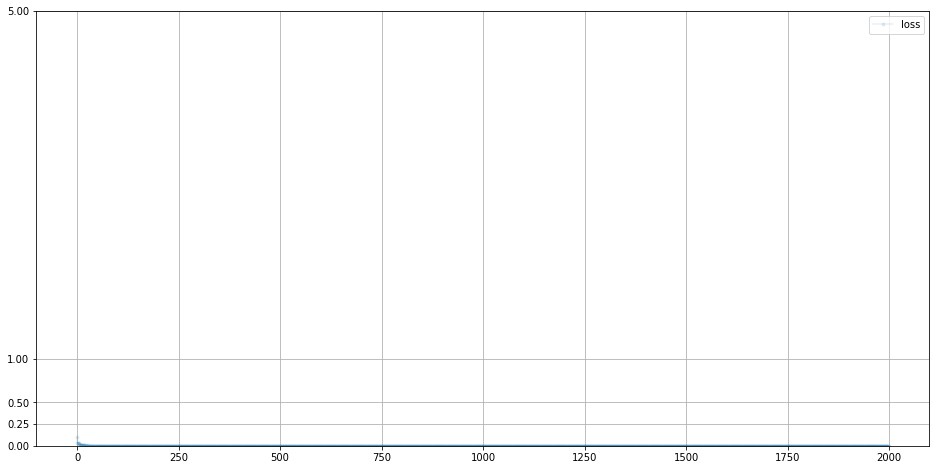

In [27]:
# 판별기 손실 플롯

D.plot_progress()

In [28]:
# 가짜와 진짜를 판별할수 있는지 판별기 직접 구동

for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,50)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784), generate_random_one_hot(10) ).item() )
  pass

0.9999998807907104
1.0
1.0
1.0
4.739278836041194e-08
4.44631957918773e-08
4.9027384818600694e-08
4.3148830286554585e-08


## 생성기 모델

In [29]:
# Generator 클래스

class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # 시드와 레이블 연결
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs, label_tensor)
        
        # 판별기에 값 전달
        d_output = D.forward(g_output, label_tensor)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## 생성기 결과 테스트

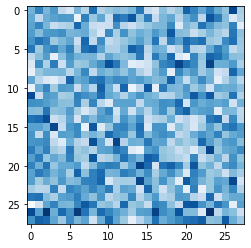

In [30]:
# 생성기의 출력이 올바른 타입과 형태를 지니고 있는지 확인

G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## GAN 훈련

In [31]:
# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

In [32]:
%%time 

# 판별기와 생성기 훈련

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for label, image_data_tensor, label_tensor in mnist_dataset:
    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # 임의의 원 핫 인코딩된 값을 레이블로 이용
    random_label = generate_random_one_hot(10)
    
    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    
    # 임의의 원 핫 인코딩된 값을 레이블로 이용
    random_label = generate_random_one_hot(10)

    # 생성기 훈련
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
CPU times: user 1min 6s, sys: 976 ms, total: 1min 7s
Wall time: 1min 7s


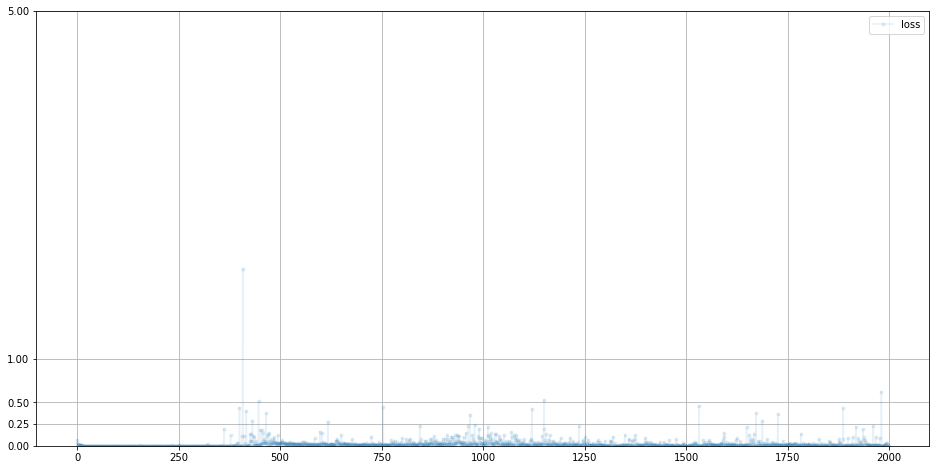

In [33]:
# 판별기 오차 플롯

D.plot_progress()

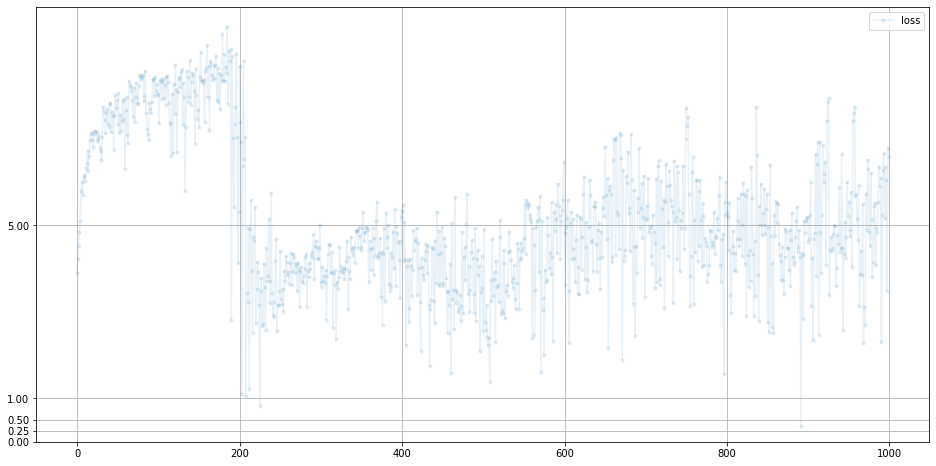

In [34]:
# 생성기 오차 플롯

G.plot_progress()

## Run Generator

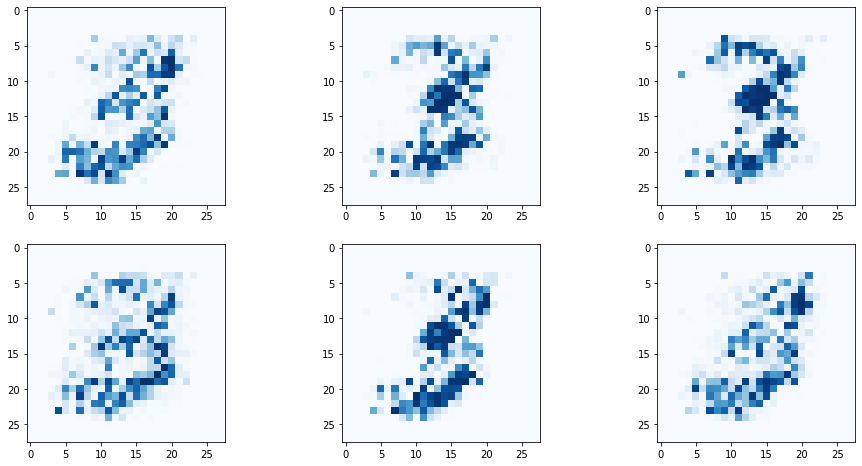

In [35]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

G.plot_images(9)

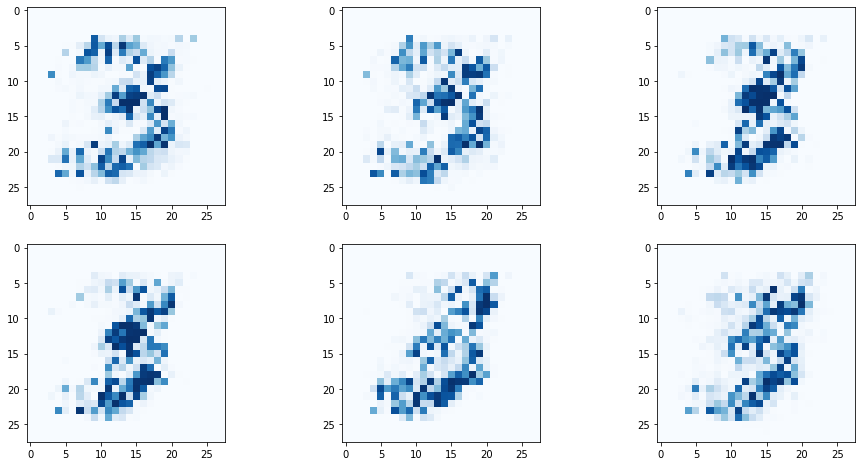

In [36]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

G.plot_images(3)

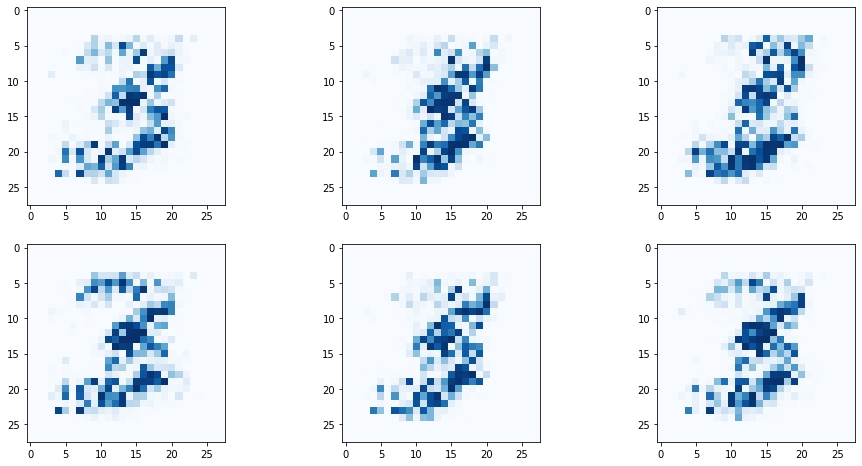

In [37]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

G.plot_images(1)

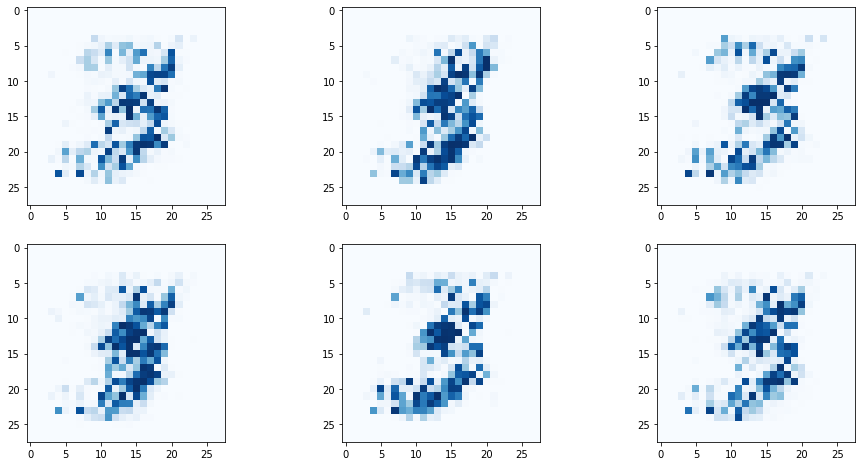

In [38]:
# 훈련된 생성기로부터 몇개의 출력을 플롯

G.plot_images(5)